In [1]:
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from scipy.special import zetac
from numba import jit
from itertools import izip, product


%matplotlib inline

In [2]:
pd.set_option('precision',7)
mpl.rcParams['figure.figsize'] = (9.0, 5.0)  # default size of plots
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 16

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['legend.framealpha'] = 0.75
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['legend.numpoints'] = 1

# mpl.rcParams.update({'font.size': 24, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


In [3]:
%config InlineBackend.figure_format='svg'
# %config InlineBackend.figure_format='retina'

# Importing CSV data 

In [4]:
!ls *.csv

4tau experimental limits - ATLAS mumutautau.csv
4tau experimental limits - ATLAS mumutautau_old.csv
4tau experimental limits - HIG-14-019.csv
4tau experimental limits - HIG-14-022- Combined.csv
4tau experimental limits - HIG-14-041 bbmumu xsec limit.csv
4tau experimental limits - HIG-15-011 (mumutautau).csv
ATLAS_HIGG_2014_02_full.csv
CMS_HIG_14_019_full.csv
CMS_HIG_14_022_full.csv
CMS_HIG_14_041_full.csv
CMS_HIG_15_011_full.csv


In [5]:
def make_all_cols_floats(df):
    for c in df.columns:
        df[c] = df[c].astype(float)

## CMS HIG-14-019 (4tau)

In [6]:
df_hig_14_019 = pd.read_csv("4tau experimental limits - HIG-14-019.csv").dropna()
make_all_cols_floats(df_hig_14_019)
df_hig_14_019

,m_a,BR(h->aa->4tau) limit,xsec*BR limit (xsec = xsec_SM_125)
0,4.0,0.368,7.1
1,5.0,0.535,10.3
2,6.0,0.446,8.6
3,7.0,0.259,5.0
4,8.0,0.234,4.5


## CMS HIG-14-022 (4tau)

In [7]:
df_hig_14_022 = pd.read_csv("4tau experimental limits - HIG-14-022- Combined.csv").dropna()
make_all_cols_floats(df_hig_14_022)

In [8]:
df_hig_14_022

,m_a,BR(h->aa->4tau) limit,xsec*BR limit (xsec = xsec_SM_125)
0,5.0,26.000,558.840
1,7.0,0.491,10.553
2,9.0,0.230,4.944
3,11.0,0.165,3.546
4,13.0,0.171,3.675
5,15.0,0.254,5.459


## CMS HIG-15-011 (2tau2mu)

In [9]:
df_hig_15_011 = pd.read_csv("4tau experimental limits - HIG-15-011 (mumutautau).csv").dropna()
make_all_cols_floats(df_hig_15_011)

In [10]:
df_hig_15_011.head()

,m_a (scraped),m_a (rounded),BR (h -> aa ->4tau),xsec * BR(h ->aa ->4tau) [pb]
0,20.0000000,20.0,0.1406977,2.7112442
1,20.4756757,20.5,0.1589414,3.0627999
2,20.9945946,21.0,0.1439110,2.7731657
3,21.5135135,21.5,0.1084872,2.0905476
4,22.0324324,22.0,0.1291456,2.4886353


## ATLAS HIGG-2014-02 (2tau2mu)

In [11]:
df_atlas_higg_2014_02 = pd.read_csv("4tau experimental limits - ATLAS mumutautau.csv").dropna()
make_all_cols_floats(df_atlas_higg_2014_02)

In [12]:
df_atlas_higg_2014_02.head()

,m_a,BR
0,3.7208100,0.0358580
1,3.7796425,0.0376421
2,3.8363947,0.0410144
3,3.8939990,0.0451355
4,3.9555699,0.0488783


## CMS HIG-14-041 (2mu2b)

In [13]:
df_hig_14_041 = pd.read_csv("4tau experimental limits - HIG-14-041 bbmumu xsec limit.csv")
make_all_cols_floats(df_hig_14_041)
df_hig_14_041.columns
df_hig_14_041['xsec*BR(h->aa->bbmumu) [pb]'] = df_hig_14_041[' xsec*BR(h->aa->bbmumu) [fb] '] / 1000.

In [14]:
df_hig_14_041.head()

,m_a (scraped),xsec*BR(h->aa->bbmumu) [fb],xsec*BR(h->aa->bbmumu) [pb]
0,27.5196850,4.7664434,0.0047664
1,28.0393701,6.7575833,0.0067576
2,28.5354331,6.7019722,0.0067020
3,29.0078740,5.1603576,0.0051604
4,29.5275591,6.4225256,0.0064225


# Tidying up

Every Dataframe should have, for each m_a:

- xsec * BR(4tau) [pb] (`xsec_br_4tau`)

- above / xsec(SM) (`br_4tau`)

- xsec * BR(2tau2mu) [pb] (`xsec_br_2tau2mu`)

- above / xsec(SM) (`br_2tau2mu`)

- xsec * BR(4mu) [pb] (`xsec_br_4mu`)

- above / xsec(SM) (`br_4mu`)


We need a function to convert between the various branching ratios, as well as a function to convert between xsec * BR to just BR

In [15]:
roman_dict = {1: 'I', 2: 'II', 3: 'III', 4: 'IV'}

def int_to_roman(i):
    """Convert integer to roman numeral. 
    Integer must in range 1 to 4.
    If no conversion exists, returns 'Z'
    """
    return roman_dict.get(i, 'Z')

In [16]:
# Some physical constants

G_F = 1.1663787E-5  # Fermi's constant, in (GeV)^-2

A_QED = 7.2973525664E-3 

sqrt2 = np.sqrt(2.)

PI = np.pi

# Quark masses in GeV. Both pole and MSBar
M_U_MSBAR = 2.3E-3

M_D_MSBAR = 4.8E-3

M_S_MSBAR = 95.0E-3

M_C_POLE = 1.67
M_C_MSBAR_AT_POLE = 1.275

M_B_POLE = 4.78
M_B_MSBAR_AT_POLE = 4.18

# update these
M_T_POLE = 178.
M_T_MSBAR_AT_POLE = 170.3

# Some common lepton masses in GeV
M_TAU = 1.776
M_MU = 0.106
M_E = 0.5109989461E-3

In [17]:
# these are for duck typing, since quark masses have to be called via functions
def m_tau(*args, **kwargs):
    return M_TAU

def m_mu(*args, **kwargs):
    return M_MU

def m_e(*args, **kwargs):
    return M_E

In [18]:
def velocity(m_f, m_a):
    """beta factor ("phase volume") in width calculation

    m_f: mass of fermion
    m_a: mass of a boson. int, float, or numpy array
    
    if 2m_f > m_a, returns 0
    """
    if isinstance(m_a, float) or isinstance(m_a, int):
        if 2. * m_f > m_a:
            return 0.
    beta = np.sqrt(1 - (2 * m_f / m_a)**2)
    if isinstance(m_a, np.ndarray):
        beta[np.isnan(beta)] = 0.
    return beta


In [19]:
m_as = np.linspace(2, 50, 100)

In [20]:
@jit
def convert_BR_final_states(m_new, m_old, m_a):
    """Get ratio of widths (ie BR) of a -> 2m_new / a -> 2m_old
    
    Uses tree-level equation A3 in 1312.4992v5 
    (note, older versions miss a sqrt in phase factor!)
    """
    return m_new**2 * velocity(m_new, m_a) / (m_old**2 * velocity(m_old, m_a))

In [21]:
@jit
def convert_4tau_to_2tau_2mu(df, xsec=True, append=None):
    """Convert from 4 tau final state to 2tau 2mu final state.

    xsec: bool. If True, uses xsec column, otherwise uses BR column.
    append : str, optional. End of column name to get values from (e.g. _typ1_tb0p5)
    """
    pre = 'xsec_' if xsec else ''
    if not append:
        append = ''
    return 2. * df['%sbr_4tau%s' % (pre, append)].values * convert_BR_final_states(M_MU, M_TAU, df['m_a'].values)

In [22]:
@jit
def convert_4tau_to_4mu(df, xsec=True, append=None):
    """Convert from 4 tau final state to 4mu final state.

    xsec: bool. If True, uses xsec column, otherwise uses BR column.
    """
    pre = 'xsec_' if xsec else ''
    return df['%sbr_4tau%s' % (pre, append)].values * convert_BR_final_states(M_MU, M_TAU, df['m_a'].values)**2

In [23]:
SM_XSEC = 19.27  # SM Higgs productionc cross-section in pb

@jit
def convert_xsec_to_br(xsec):
    """Convert from xsec * BR to just BR, assuming SM xsec."""
    return xsec / SM_XSEC

@jit
def convert_br_to_xsec(br):
    """Convert from BR to xsec * BR, assuming SM xsec."""
    return br * SM_XSEC

In [24]:
@jit
def calc_other_final_states(df, append=None):
    """Do all necessary mappings from 4tau final state to other final states."""
    if not append:
        append = ''
    # Do xsec * BR
    fname = 'xsec_br_4tau%s' % (append)
    if fname in df.columns:
        df['xsec_br_2tau2mu%s' % append] = convert_4tau_to_2tau_2mu(df, xsec=True, append=append)
        df['xsec_br_4mu%s' % append] = convert_4tau_to_4mu(df, xsec=True, append=append)
    else:
        print 'Cannot calculate other final state xsec - no %s field' % fname

    # Do BR
    fname = 'br_4tau%s' % (append)
    if fname in df.columns:
        df['br_2tau2mu%s' % append] = convert_4tau_to_2tau_2mu(df, xsec=False, append=append)
        df['br_4mu%s' % append] = convert_4tau_to_4mu(df, xsec=False, append=append)
    else:
        print 'Cannot calculate other final state BR - no %s field' % fname

## CMS HIG-14-019

In [25]:
df_hig_14_019.columns

Index([u'm_a', u'BR(h->aa->4tau) limit',
       u'xsec*BR limit (xsec = xsec_SM_125)'],
      dtype='object')

In [26]:
df_hig_14_019.rename(columns={'xsec*BR limit (xsec = xsec_SM_125)': 'xsec_br_4tau', 
                              'BR(h->aa->4tau) limit': 'br_4tau'}, 
                     inplace=True)

calc_other_final_states(df_hig_14_019)

/Users/robina/.virtualenvs/NMSSMScan/lib/python2.7/site-packages/numba/dataflow.py:297: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


In [27]:
df_hig_14_019

,m_a,br_4tau,xsec_br_4tau,xsec_br_2tau2mu,xsec_br_4mu,br_2tau2mu,br_4mu
0,4.0,0.368,7.1,0.1098483,0.0004249,0.0056935,0.0000220
1,5.0,0.535,10.3,0.1041728,0.0002634,0.0054109,0.0000137
2,6.0,0.446,8.6,0.0759769,0.0001678,0.0039402,0.0000087
3,7.0,0.259,5.0,0.0413213,0.0000854,0.0021404,0.0000044
4,8.0,0.234,4.5,0.0357680,0.0000711,0.0018599,0.0000037


## CMS HIG-14-022 (4tau)

In [28]:
df_hig_14_022.columns

Index([u'm_a', u'BR(h->aa->4tau) limit',
       u'xsec*BR limit (xsec = xsec_SM_125)'],
      dtype='object')

In [29]:
df_hig_14_022.rename(columns={'xsec*BR limit (xsec = xsec_SM_125)': 'xsec_br_4tau', 
                              'BR(h->aa->4tau) limit': 'br_4tau'}, 
                     inplace=True)
calc_other_final_states(df_hig_14_022)

In [30]:
df_hig_14_022

,m_a,br_4tau,xsec_br_4tau,xsec_br_2tau2mu,xsec_br_4mu,br_2tau2mu,br_4mu
0,5.0,26.000,558.840,5.6520297,0.0142910,0.2629604,0.0006649
1,7.0,0.491,10.553,0.0872127,0.0001802,0.0040577,0.0000084
2,9.0,0.230,4.944,0.0383249,0.0000743,0.0017829,0.0000035
3,11.0,0.165,3.546,0.0266886,0.0000502,0.0012419,0.0000023
4,13.0,0.171,3.675,0.0272147,0.0000504,0.0012663,0.0000023
5,15.0,0.254,5.459,0.0400273,0.0000734,0.0018624,0.0000034


## CMS HIG-15-011 (2tau2mu)

In [31]:
df_hig_15_011.columns

Index([u'm_a (scraped)', u'm_a (rounded)', u'BR (h -> aa ->4tau)',
       u'xsec * BR(h ->aa ->4tau) [pb]'],
      dtype='object')

In [32]:
df_hig_15_011.rename(columns={'m_a (rounded)': 'm_a',
                              'xsec * BR(h ->aa ->4tau) [pb]': 'xsec_br_4tau', 
                              'BR (h -> aa ->4tau)': 'br_4tau'}, 
                     inplace=True)
df_hig_15_011.drop('m_a (scraped)', 1, inplace=True)

calc_other_final_states(df_hig_15_011)

In [33]:
df_hig_15_011.head()

,m_a,br_4tau,xsec_br_4tau,xsec_br_2tau2mu,xsec_br_4mu,br_2tau2mu,br_4mu
0,20.0,0.1406977,2.7112442,0.0196273,0.0000355,0.0010185,0.0000018
1,20.5,0.1589414,3.0627999,0.0221549,0.0000401,0.0011497,0.0000021
2,21.0,0.1439110,2.7731657,0.0200453,0.0000362,0.0010402,0.0000019
3,21.5,0.1084872,2.0905476,0.0151009,0.0000273,0.0007837,0.0000014
4,22.0,0.1291456,2.4886353,0.0179652,0.0000324,0.0009323,0.0000017


## ATLAS HIGG-2014-02 (2tau2mu)

In [34]:
df_atlas_higg_2014_02.columns

Index([u'm_a', u' BR'], dtype='object')

In [35]:
df_atlas_higg_2014_02.rename(columns={' BR': 'br_4tau', 
                                       'xsec * BR': 'xsec_br_4tau'},
                              inplace=True)
df_atlas_higg_2014_02['xsec_br_4tau'] = convert_br_to_xsec(df_atlas_higg_2014_02['br_4tau'])

In [36]:
df_atlas_higg_2014_02.head()

,m_a,br_4tau,xsec_br_4tau
0,3.7208100,0.0358580,0.6909834
1,3.7796425,0.0376421,0.7253632
2,3.8363947,0.0410144,0.7903479
3,3.8939990,0.0451355,0.8697612
4,3.9555699,0.0488783,0.9418852


In [37]:
calc_other_final_states(df_atlas_higg_2014_02)

In [38]:
df_atlas_higg_2014_02.head()

,m_a,br_4tau,xsec_br_4tau,xsec_br_2tau2mu,xsec_br_4mu,br_2tau2mu,br_4mu
0,3.7208100,0.0358580,0.6909834,0.0165046,0.0000986,0.0008565,0.0000051
1,3.7796425,0.0376421,0.7253632,0.0150956,0.0000785,0.0007834,0.0000041
2,3.8363947,0.0410144,0.7903479,0.0148798,0.0000700,0.0007722,0.0000036
3,3.8939990,0.0451355,0.8697612,0.0150985,0.0000655,0.0007835,0.0000034
4,3.9555699,0.0488783,0.9418852,0.0152275,0.0000615,0.0007902,0.0000032


## CMS HIG-14-041 (2mu2b)

In [39]:
df_hig_14_041.columns

Index([u'm_a (scraped)', u' xsec*BR(h->aa->bbmumu) [fb] ',
       u'xsec*BR(h->aa->bbmumu) [pb]'],
      dtype='object')

In [40]:
df_hig_14_041.rename(columns={'m_a (scraped)': 'm_a',
                              'xsec*BR(h->aa->bbmumu) [pb]': 'xsec_br_2b2mu'},
                    inplace=True)
df_hig_14_041['br_2b2mu'] = convert_xsec_to_br(df_hig_14_041.xsec_br_2b2mu.values)
df_hig_14_041.drop([' xsec*BR(h->aa->bbmumu) [fb] '], 1, inplace=True)

In [41]:
df_hig_14_041.head()

,m_a,xsec_br_2b2mu,br_2b2mu
0,27.5196850,0.0047664,0.0002474
1,28.0393701,0.0067576,0.0003507
2,28.5354331,0.0067020,0.0003478
3,29.0078740,0.0051604,0.0002678
4,29.5275591,0.0064225,0.0003333


#  Plotting

In Type1/2 models, the bottom and tau/mu both have the same relative coupling strength to a. Therefore we can convert easily, without any $\tan(\beta)$ dependence.

In [42]:
dfs_dict = [
    {'df': df_hig_14_019, 'label': 'CMS HIG-14-019 '+r'$(4\tau)$', 'color': 'blue'},
    {'df': df_hig_14_022, 'label': 'CMS HIG-14-022 '+r'$(4\tau)$', 'color': 'green'},
    {'df': df_hig_15_011, 'label': 'CMS HIG-15-011 '+r'$(2\tau2\mu)$', 'color': 'orange'},
    {'df': df_atlas_higg_2014_02, 'label': 'ATLAS HIGG-2014-02 '+r'$(2\tau2\mu)$', 'color': 'red'},
]

In [43]:
def plot_exclusion_regions(dfs_dict, y_var, y_label, x_range=None, y_range=None, 
                           title=None, shade=True, text=None, text_coords=[0.6, 0.1]):
    """Make a plot of exclusion regions.

    Parameters
    ----------
    dfs_dict : list
        List of dictionaries, one for each dataframe to be plotted. 
        Must contain fields for dataframe (df), label, color.
    
    y_var : str
        Variable to plot on y axis. Must correspond to column name in dataframe.

    y_label : str
        Label for y axis
        
    x_range : list/tuple, Optional
        Limits for x axis range
        
    y_range : list/tuple, Optional
        Limits for y axis range
    
    title : str, Optional
        Title for plot
        
    shade : bool, Optional
        If True, shades exclusion region in semi-transparent color.
        
    text : str, Optional
        Text to put on plot.
    """
    for entry in dfs_dict:
        df = entry['df']
        plt.plot(df['m_a'].values, df[y_var].values, 
                 label=entry['label'], 
                 color=entry['color'], linewidth=2)
    
    if x_range:
        plt.xlim(*x_range)
    if y_range:
        plt.ylim(*y_range)

    plt.yscale('log')
    
    if shade:
        y_top = plt.ylim()[1]
        for entry in dfs_dict:
            df = entry['df']
            upper_edge = np.ones_like(df[y_var]) * y_top
            plt.fill_between(df['m_a'], df[y_var], 
                             y2=upper_edge,
                             color=entry['color'],
                             alpha=0.2)
            
    plt.minorticks_on()
    plt.xlabel(r'$m_a\ \mathrm{[GeV]}$', fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    plt.legend(loc=0, fontsize=14)
#     plt.xscale('log')

    if title:
        plt.suptitle(title)

    if text:
        plt.text(*text_coords, s=text, transform=plt.gca().transAxes)
    
    # line for mh/2    
    mh = 125.
    plt.vlines(mh/2, *plt.ylim(), linestyle='dotted', color='dimgrey', linewidth=2)
    plt.annotate(r'$m_h/2$', xy=(mh/2, plt.ylim()[0]), 
                 xytext=(5, 20), xycoords='data', 
                 textcoords='offset points', 
                 fontsize=16, color='dimgrey')

In [44]:
def draw_xsec_sm():
    """Draw a horizontal line at xsec_SM"""
    xlim = plt.xlim()
    plt.hlines(19.27, *xlim, linestyle='dashed')
    plt.annotate(r'$\sigma_{SM}$', xy=(xlim[0], 19.27),
                 xytext=(5, 5), xycoords='data', 
                 textcoords='offset points', fontsize=16)
    
def draw_hline_1():
#     xlim = plt.xlim()
    plt.hlines(1, *plt.xlim(), linestyle='dashed')

## 4tau

/Users/robina/.virtualenvs/NMSSMScan/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


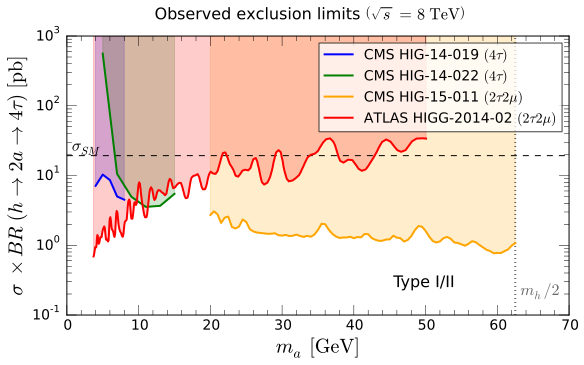

In [45]:
plot_exclusion_regions(dfs_dict, 
                       y_var='xsec_br_4tau', 
                       y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\tau)\ \mathrm{[pb]}$', 
                       y_range=[0.1, 1E3],
                       title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
                       text='Type I/II', text_coords=[0.65, 0.1])
draw_xsec_sm()
plt.savefig("plots/xsec_br_4tau_type1.svg")

In [46]:
# plot_exclusion_regions(dfs_dict, 
#                        y_var='br_4tau', 
#                        y_label=r'$\frac{\sigma}{\sigma_{SM}} \times BR\ (h\ \to\ 2a\ \to\ 4\tau)$', 
# #                        y_range=[1E-7, 1E-2],
#                        title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                        text='Type I/II', text_coords=[0.65, 0.1])
# draw_hline_1()
# plt.savefig("plots/br_4tau_type1.svg")

## 2tau 2mu

In [47]:
# plot_exclusion_regions(dfs_dict, 
#                        y_var='xsec_br_2tau2mu', 
#                        y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 2\tau2\mu)\ \mathrm{[pb]}$', 
#                        y_range=[1E-3, 10],
#                        title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                        text='Type I/II', text_coords=[0.65, 0.1])
# draw_xsec_sm()
# plt.savefig("plots/xsec_br_2tau2mu_type1.svg")

In [48]:
# plot_exclusion_regions(dfs_dict, 
#                        y_var='br_2tau2mu', 
#                        y_label=r'$\frac{\sigma}{\sigma_{SM}} \times BR\ (h\ \to\ 2a\ \to\ 2\tau2\mu)$', 
#                        y_range=[5E-5, 1],
#                        title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                        text='Type I/II', text_coords=[0.65, 0.1])
# plt.savefig("plots/br_2tau2mu_type1.svg")

## 4 mu

In [49]:
# plot_exclusion_regions(dfs_dict, 
#                        y_var='xsec_br_4mu', 
#                        y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\mu)\ \mathrm{[pb]}$', 
#                        y_range=[1E-6, 1E-1],
#                        title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                        text='Type I/II', text_coords=[0.65, 0.1])
# plt.savefig("plots/xsec_br_4mu_type1.svg")

In [50]:
# plot_exclusion_regions(dfs_dict, 
#                        y_var='br_4mu', 
#                        y_label=r'$\frac{\sigma}{\sigma_{SM}} \times BR\ (h\ \to\ 2a\ \to\ 4\mu)$', 
#                        y_range=[5E-8, 1E-2],
#                        title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                        text='Type I/II', text_coords=[0.65, 0.1])
# plt.savefig("plots/br_4mu_type1.svg")

# Adding in $a\to bb$ & tan($\beta$) dependence - Type III/IV models

$\tan\beta = \text{v}_2/\text{v}_1$

|Coupling/Type| I | II | III | IV|
|--------------------------------|
|$g_{a\tau\tau}$ | $H_2\\ (-\cot\beta)$ | $H_1\\ (\tan\beta)$ | $H_1\\ (\tan\beta)$ | $H_2\\ (-\cot\beta)$ |
|$g_{abb}$ | $H_2\\ (-\cot\beta)$ | $H_1\\ (\tan\beta)$ | $H_2\\ (-\cot\beta)$ | $H_1\\ (\tan\beta)$ |
|$g_{att}$ | $H_2\\ (\cot\beta)$ | $H_2\\ (\cot\beta)$ | $H_2\\ (\cot\beta)$ | $H_2\\ (\cot\beta)$ |

We need some functions to calculate the various BR ratios for b<=>tau/mu, for various m_a, for various tan(beta). Remember, we **observe** a limit on a particular process independent of the model. But to recast that limit **in another channel** we need the correct transfer factors.

We use formulae A3 - A8 in 1312.4992v5.

\begin{equation}
\Gamma(a\to \ell\ell) = \frac{G_F}{4\sqrt{2}\pi}g_{a\ell\ell}^2 m_a m_{\ell}^2\sqrt{1-\left(\frac{2m_{\ell}}{m_a}\right)^2}
\\
\Gamma(a\to q\bar{q}) = \frac{3 G_F}{4\sqrt{2}\pi}g_{aqq}^2 m_a m_q^2\sqrt{1-\left(\frac{2\bar{m}_q}{m_a}\right)^2} \left(1 + \Delta_{q\bar{q}} + \Delta_a^2\right)
\\
\mathrm{where\ the\ corrections\ are}
\\
\Delta_{q\bar{q}} = 5.67\frac{\bar{\alpha}_s}{\pi} +(35.64 -1.35N_f)\left(\frac{\bar{\alpha}_s}{\pi}\right)^2
\\
\Delta_a^2 = \left(\frac{\bar{\alpha}_s}{\pi}\right)^2 \left(3.83 - \ln\frac{m_a^2}{m_t^2} + \frac{1}{6}\ln^2\frac{\bar{m}_q^2}{m_a^2} \right)
\end{equation}

Where $N_f$ is the number of active light quarks, $\bar{\alpha}_s$ is the running strong coupling constant, and $\bar{m}_q$ is the running quark mass in the $\overline{MS}$ scheme. The latter two are at renormalisation scale $\mu = m_a$.

Therefore we need to calculate:

- running of $\bar{\alpha}_s$

- running of $\bar{m}_b$

For Type III, $\frac{g_{aqq}}{g_{a\tau\tau}} = \frac{1}{\tan^2\beta}$. For Type IV, it is the inverse.

(So in Type III, large $\tan\beta$ = larger $BR(a\to\tau\tau)$)

## Running of $\alpha_s$

References: 

- http://pdg.lbl.gov/2015/reviews/rpp2015-rev-qcd.pdf

- QCDNUM: https://www.nikhef.nl/~h24/qcdnum-files/doc/qcdnum170007.pdf

- A. Djouadi: Anatomy of EWSB I and II, arxiv:0503172, arxiv:0503173 

- Exotic Decays of the 125GeV Higgs Boson (Strassler et al), arxiv:1312.4992v5

Working in petrubative QCD (pQCD), the running of the coupling constant is determined by the renormalisation group equation (RGE) (PDG eq9.3):

\begin{equation}
\mu_R^2\frac{d\alpha_s^{(N_f)}}{d\mu_R^2} = \frac{d\alpha_s^{(N_f)}}{d\ln\mu_R^2} = \beta(\alpha_s^{(N_f)}) = -\sum_{i=0}^{\infty}b_i {\alpha_s^{(N_f)}}^{i+2}
\end{equation}

where the factors $b_i$ up to 3-loop are given by (b3 from 9701390v1):

\begin{align}
b_0 &= (33 - 2N_f)/(12\pi)
\\
b_1 &= (153 - 19N_f)/(24\pi^2)
\\
b_2 &= (2857 - \frac{5033}{9}N_f + \frac{325}{27}N_f^2)/(128\pi^3)
\\
b_3 &= \left( \left(\frac{149753}{6} + 3564N_f \right) - \left( \frac{1078361}{162} + \frac{6508}{27}\zeta(3)\right)N_f + \left( \frac{50065}{162} + \frac{6472}{81}\zeta(3) \right) N_f^2 + \frac{1093}{729}N_f^3 \right) / (\pi^4)
\end{align}

where $N_f$ is the number of "light" flavours $(m_q \ll \mu_R)$. The remaining flavours decouple from the theory. $\zeta$ is the Riemann zeta function ($\zeta(3) \simeq 1.202...$)

Note that the - sign is crucial for asymptotic freedom: higher scale = weaker coupling.

$b_i$ = "i+1 loop $\beta$-function coeff."

Note that the expressions for $b_i$ are scheme-dependent. Here we always work in the $\overline{MS}$ scheme.

Note that if one only considers $b_0$, a simple analytic solution exists:

\begin{equation}
\alpha_s(\mu_R^2) = \frac{1}{b_0\ln\left(\mu_R^2/\Lambda^2\right)}
\end{equation}

where $\Lambda$ is a constant, representing the limit to which pQCD can be applied before non-perturbative effectes render the approach invalid.

Considering higher orders, an approximate analytic solution exists up to 3-loop order (PDG eq9.5):

\begin{equation}
\alpha_s(\mu_R^2) \simeq \frac{1}{b_0t}\left(1 - \frac{b_1}{b_0^2}\frac{\ln t}{t} + \frac{b_1^2\left(\ln^2 t- \ln t - 1 \right)+b_0 b_2}{b_0^4 t^2} - \frac{b_1^3 \left( \ln^3t -\frac{5}{2}\ln^2t -2\ln t + \frac{1}{2} \right) + 3b_0 b_1 b_2\ln t - \frac{1}{2}b_0^2 b_3}{b_0^6 t^3} \right)
\end{equation}

where

\begin{equation}
t = \ln \frac{\mu_R^2}{\Lambda^2}
\end{equation}

Another subtelty enters when one considers the number of quarks contributing to $N_f$. When $\mu$ exceeds a heavier quark mass, it must be included. To relate the coupling for $N_F+1$ to $N_f$, the following formula is used (PDG eq9.4):

\begin{equation}
\alpha_s^{(N_f+1)}(\mu_R^2) = \alpha_s^{(N_f)}\left( 1 + \sum_{n=1}^\infty \sum_{\ell=0}^n c_{n\ell} \left[  \alpha_s^{(N_f)}\left( \mu_R^2 \right)\right]^n \ln^\ell \frac{\mu_R^2}{m_Q} \right)
\end{equation}

where $m_Q$ is the flavour of the $(N_f+1)$ quark. The first few constants $c_{n\ell}$ are:

\begin{align}
c_{10} &= 0
\\
c_{11} &= 1/6\pi
\\
c_{20} &= -11/(72\pi^2)
\\
c_{21} &= 19/(24\pi^2)
\\
c_{22} &= 1/(36\pi^2)
\end{align}

These are valid when $m_Q$ is the $\overline{MS}$ mass at scale $m_Q$. If the pole mass is used, the only difference is now $c_{20} = 7/(24\pi^2)$

So there are 2 approaches that can be used to calculate $\alpha_s$ at any scale, starting from a reference value at a given scale $\mu_{ref}$ with a given $N_f$. Typically $\alpha_s(M_Z^2) = 0.1181$ is used

1) Determine $\Lambda$ via the approximate analytic solution. From there, one can determine $\alpha_s$ at any other scale.

2) Solve the RGE using $\alpha_s(\mu^2)|_{\mu = \mu_{ref}} = \alpha_s(\mu_{ref}^2)$

Handily, the PDG has calcualted $\Lambda^{(N_f)}_{\overline{MS}}$ for the above reference value of $\alpha_s$ using the approximate analytic expression to 4-loop, and 3-loop matching at pole masses 1.3 (c), 4.2 (b), and 173 (t) GeV.

**Note** that these are only valid down to a few GeV - below that the analystic expression isn't very accurate, and one must solve the RGE.

\begin{align}
\Lambda_{\overline{MS}}^{(6)} &= 89\ \mathrm{MeV}
\\
\Lambda_{\overline{MS}}^{(5)} &= 210\ \mathrm{MeV}
\\
\Lambda_{\overline{MS}}^{(4)} &= 291\ \mathrm{MeV}
\\
\Lambda_{\overline{MS}}^{(3)} &= 332\ \mathrm{MeV}
\end{align}

In [51]:
@jit
def n_flav(mu):
    """Return number of light flavours, 
    i.e. number of quarks with mass < mu"""
    if mu < M_C_POLE:
        return 3
    elif mu < M_B_POLE:
        return 4
    elif mu < M_T_POLE:
        return 5
    else:
        return 6

In [52]:
zeta3 = zetac(3)+1

@jit
def alpha_s(mu, nflav=None, simple=False):
    """Calculate strong coupling constant at any scale.

    simple : bool. Do 1-loop only. Overly large at small mu, but faster.
    """

    if not nflav:
        nflav = n_flav(mu)

    lambda_ = 0  # use underscore to avoid clashing with python builtin        
    if nflav == 3:
        lambda_ = 0.332
    elif nflav == 4:
        lambda_ = 0.291
    elif nflav == 5:
        lambda_ = 0.210
    elif nflav == 6:
        lambda_ = 0.089
    else:
        raise RuntimeError('n_flav no in range [3, 6] for alpha_s')
        
    # RGE constants, using PDG convention
    b0 = (33. - 2.*nflav) / (12. * PI)
    
    if simple:
        return 1. / (b0 * np.log(mu**2/lambda_**2))

    b1 = (153 - 19*nflav) / (24. * PI**2)
    
    b2 = (2857 - (5033. * nflav / 9.) + (325. * nflav**2 / 27.)) / (128. * PI**3)
    
    
    b3_0 = ((149753/6.) + (3564.*zeta3))
    b3_1 = ((1078361./162.) + (6508.*zeta3/27.)) * nflav
    b3_2 = ((50065./162.) + (6472.*zeta3/81.)) * nflav**2 
    b3_3 = (1093./729.) * nflav**3
    b3 = (b3_0 - b3_1 + b3_2 + b3_3) / (256. * PI**4)
   
    # calculate the analytic approximation, using PDG convention
    t = np.log((mu**2) / (lambda_**2))
    lnt = np.log(t)
    
    part1 = 1
    part2 = ((b1 * lnt) / (b0**2 * t))
    part3 = ((b1**2 * (lnt**2 - lnt - 1)) + (b0*b2)) / (b0**4 * t**2)
    part4 = (b1**3 * (lnt**3 - (2.5*lnt**2) - (2*lnt) + 0.5) + (3*b0*b1*b2*lnt) - (0.5 * b0**2 * b3)) / (b0**6 * t**3)
    return (part1 - part2 + part3 - part4) / (b0*t)

# print 'MZ', alpha_s(91.1882, 5), 'should be 0.1181'

In [53]:
# Calculate a_s for various scales, covering 1 GeV to 2 TeV,
# comparing 4 loop with 1 loop

# For lin x scale:
# Q_ranges = [np.linspace(1, 1.3, 100), np.linspace(1.3, 4.2, 100), 
#             np.linspace(4.2, 173, 100), np.linspace(173, 2000, 100)]

# For log x scale:
Q_ranges = [np.logspace(0, np.log10(1.3), 20), np.logspace(np.log10(1.3), np.log10(4.2), 20), 
            np.logspace(np.log10(4.2), np.log10(173), 50), np.logspace(np.log10(173), np.log10(2000), 100)]
Q = np.concatenate(Q_ranges)

a_s = np.concatenate([alpha_s(qr, i+3) for i, qr in enumerate(Q_ranges)])
a_s_1loop = np.concatenate([alpha_s(qr, i+3, True) for i, qr in enumerate(Q_ranges)])

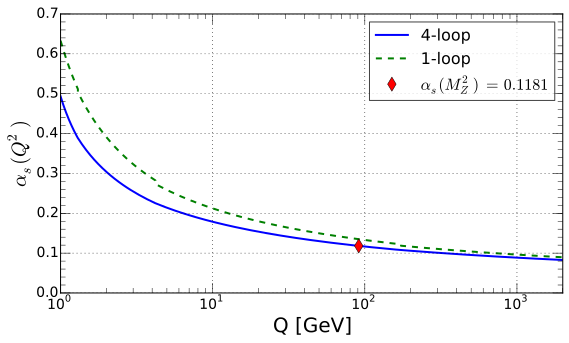

In [54]:
plt.plot(Q, a_s, label='4-loop', linewidth=2)
plt.plot(Q, a_s_1loop, label='1-loop', linestyle='dashed', linewidth=2)
plt.plot([91.1876], [0.1181], 'dr', label=r'$\alpha_s(M_Z^2)\ =\ 0.1181$', markersize=10)
plt.xlim(1, 2000)
plt.xscale('log')
plt.xlabel('Q [GeV]', fontsize=20)
# plt.ylim(0.05, 0.4)
plt.ylabel(r'$\alpha_s(Q^2)$', fontsize=20)
plt.legend(fontsize=16, loc=0)
plt.minorticks_on()
plt.grid()

## Running of quark masses 

The renormalisation group equations for mass are:

\begin{equation}
\mu^2\frac{d\overline{m}(\mu)}{d\mu^2} = -\gamma(\overline{\alpha}_s(\mu))\overline{m}(\mu)
\end{equation}

where $\mu$ is the scale parameter, $\overline{m}$ is the running mass in the $\overline{MS}$ scheme, $\overline{\alpha}_s$ the running strong coupling, and $\gamma$ the "anomalous dimension".

$\gamma$ can be written as a power series expansion with coefficients $\gamma_r$:

\begin{equation}
\gamma(\overline{\alpha}_s) = \sum_{r=1}^{\infty} \gamma_r \left(\frac{\overline{\alpha}_s}{4\pi} \right)^r
\end{equation}

The first 4 coefficents are:

\begin{align}
\gamma_1 &= 4
\\
\gamma_2 &= \frac{202}{3} - \frac{20N_L}{9}
\\
\gamma_3 &= 1249 + \left( -\frac{2216}{27} - \frac{160}{3}\zeta(3)\right)N_L - \frac{140}{81}N_L^2
\\
\gamma_4 &= \frac{4603055}{162} + \frac{135680}{27}\zeta(3) - 8800\zeta(5) 
\\
&+ \left( - \frac{91723}{27} -\frac{34192}{9}\zeta(3) + 880\zeta(4) + \frac{18400}{9}\zeta(5) \right)N_L 
\\ 
&+ \left(\frac{5242}{243} + \frac{800}{9}\zeta(3) - \frac{160}{3}\zeta(4) \right)N_L^2 
\\
&+ \left(-\frac{332}{243} + \frac{64}{27}\zeta(3) \right)N_L^3 
\end{align}

where $N_L$ is the number of active "light" quark flavours, i.e. with mass < $\mu$. $\zeta$ is the Riemann zeta function. $\zeta(3) \simeq 1.202,\ \zeta(4) \simeq 1.082,\ \zeta(5) \simeq 1.037$.

We can combine the RGE for $\alpha_s$ into the RGE for mass The mass at a scale $\mu$ can be calculated from a reference mass at a reference scale $\overline{m}(\mu_0)$:

\begin{equation}
\frac{\overline{m}(\mu)}{\overline{m}(\mu_0)} = \frac{c(\overline{\alpha}_s(\mu)/\pi)}{c(\overline{\alpha}_s(\mu_0)/\pi)}
\end{equation}

where the function c, up to 3-loop, is:

\begin{align}
c(x) = \text{some very long formula I can't be arsed with}
\end{align}

An approximation is given by [Djouadi]:

\begin{align}
c(x) &= (25x/6)^{12/25}\left( 1 + 1.014x + 1.389x^2 + 1.091x^3\right) &m_c < \mu < m_b
\\
c(x) &= (23x/6)^{12/23}\left(1 + 1.175x + 1.501x^2 + 0.1725x^3\right) &m_b < \mu < m_t
\\
c(x) &= (7x/2)^{4/7} \left(1 + 1.398x + 1.793x^2 - 0.6834x^3\right) &m_t < \mu
\end{align}

To convert the pole mass $m_Q$ to $\overline{MS}$ mass $\overline{m}_Q$, the following eqatuion is used (up to 3 loop):

\begin{align}
\overline{m}_Q(m_Q) = m_Q \left( 1 - \frac{4}{3}\frac{\alpha_s(m_Q)}{\pi} \right)
\end{align}

In [55]:
@jit
def c_4flav(x):
    return (25. * x / 6.)**(12./25.) * (1 + 1.014*x + 1.389*x**2 + 1.091*x**3)

In [56]:
@jit
def c_5flav(x):
    return (23. * x / 6.0)**(12./23.) * (1 + 1.175*x + 1.501*x**2 + 0.1725*x**3)

In [57]:
@jit
def c_6flav(x):
    return (7. * x / 2.)**(4./7.) * (1 + 1.398*x + 1.793*x**2 - 0.6834*x**3)

In [58]:
@jit
def c(mu):
    if mu < M_C_POLE:
        raise RuntimeError('mu < M_C - cannot calculate c(x)')
    elif mu < M_B_POLE:
        x = alpha_s(mu, 4) / PI
        return c_4flav(x)
    elif mu < M_T_POLE:
        x = alpha_s(mu, 5) / PI
        return c_5flav(x)
    else:
        x = alpha_s(mu, 6) / PI
        return c_6flav(x)

In [59]:
@jit
def m_msbar(mu, m_ref, mu_ref):
    """Convert MSbar mass m_ref at scale mu_ref to MSbar mass at scale mu."""
    return m_ref * c(mu) / c(mu_ref)

In [60]:
@jit
def m_c_msbar(mu):
    return m_msbar(mu, m_ref=M_C_MSBAR_AT_POLE, mu_ref=M_C_POLE)

@jit
def m_b_msbar(mu):
    return m_msbar(mu, m_ref=M_B_MSBAR_AT_POLE, mu_ref=M_B_POLE)

@jit
def m_t_msbar(mu):
    return m_msbar(mu, m_ref=M_T_MSBAR_AT_POLE, mu_ref=M_T_POLE)

In [61]:
print m_c_msbar(M_C_POLE)
print m_b_msbar(M_B_POLE)
print m_t_msbar(M_T_POLE)

1.275
4.18
170.3


In [62]:
# print m_c_msbar(100)
print m_b_msbar(100)
print m_t_msbar(100)

2.90534094968
206.227132912


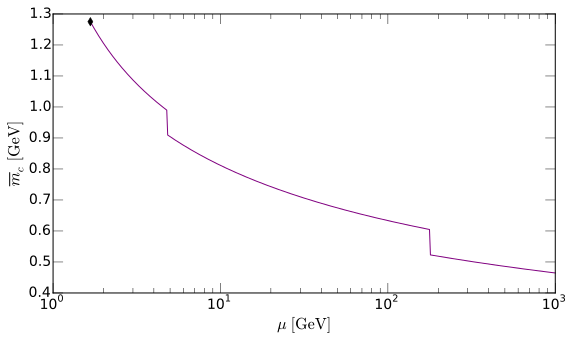

In [63]:
mu_range = np.logspace(np.log10(M_C_POLE), 3, 500)
m_c_range = np.array([m_c_msbar(muc) for muc in mu_range])
plt.plot(mu_range, m_c_range, color='purple')
plt.plot([M_C_POLE], [M_C_MSBAR_AT_POLE], 'dk')
# plt.plot([1,10], [1,10])
plt.xscale('log')
plt.xlabel(r'$\mu \mathrm{\ [GeV]}$')
plt.ylabel(r'$\overline{m}_c \mathrm{\ [GeV]}$')

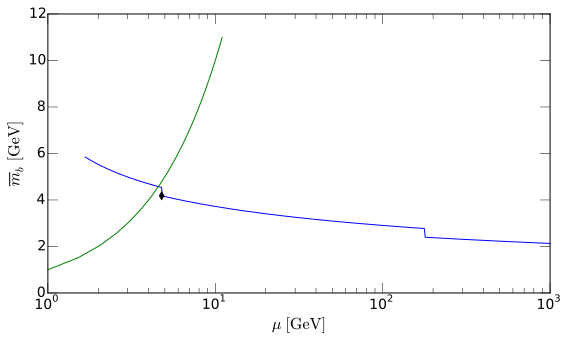

In [64]:
m_b_range = np.array([m_b_msbar(mub) for mub in mu_range])
plt.plot(mu_range, m_b_range)
plt.plot([M_B_POLE], [M_B_MSBAR_AT_POLE], 'dk')
plt.plot(np.linspace(1, 11, 20), np.linspace(1, 11, 20))
plt.xscale('log')
plt.xlabel(r'$\mu \mathrm{\ [GeV]}$')
plt.ylabel(r'$\overline{m}_b \mathrm{\ [GeV]}$')

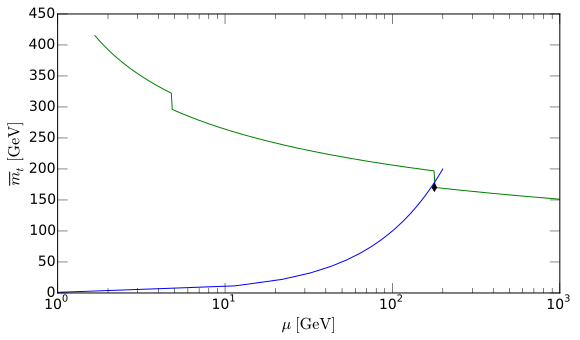

In [65]:
m_t_range = np.array([m_t_msbar(mut) for mut in mu_range])
plt.plot(mu_range, m_t_range, color='green')
plt.plot([M_T_POLE], [M_T_MSBAR_AT_POLE], 'dk')
plt.plot(np.linspace(1, 200, 20), np.linspace(1, 200, 20))
plt.xscale('log')
plt.xlabel(r'$\mu \mathrm{\ [GeV]}$')
plt.ylabel(r'$\overline{m}_t \mathrm{\ [GeV]}$')

Now we need various formulae to convert BR, as well as calculating the exact BR.

In [66]:
def g_aqq_up(model_type, tan_beta):
    """a-quark-quark (up quark type) coupling"""
    return 1./tan_beta

In [67]:
def g_aqq_down(model_type, tan_beta):
    """a-quark-quark (down quark type) coupling"""
    if model_type in [1, 3]:
        return 1./tan_beta
    elif model_type in [2, 4]:
        return tan_beta
    else:
        raise RuntimeError("model_type must be one of [1, 2, 3, 4]")

In [68]:
def g_all(model_type, tan_beta):
    """a-lepton-lepton coupling"""
    if model_type in [1, 4]:
        return 1./tan_beta
    elif model_type in [2, 3]:
        return tan_beta
    else:
        raise RuntimeError("model_type must be one of [1, 2, 3, 4]")

In [69]:
n_flav(np.linspace(1, 10, 5))

3

In [70]:
@jit
def rad_corr(m_q, m_a):
    """Calculate radiative corrections for aqq coupling."""
    NF = n_flav(m_a)
    a_s_ov_pi = alpha_s(m_a, NF) / PI
    delta_qq = (5.67 * a_s_ov_pi) + (35.94 - 1.35*NF)*a_s_ov_pi**2
    delta_a2 = a_s_ov_pi**2 * (3.83 - np.log((m_a / M_T_POLE)**2) + (np.log((m_q / m_a)**2)**2)/6.)
    return 1 + delta_qq + delta_a2

In [71]:
def width_a_lepton_common(m_a, m_l, model_type, tan_beta):
    if 2*m_l > m_a:
        return 0
    return g_all(model_type, tan_beta)**2 * m_l**2 * velocity(m_l, m_a)

In [72]:
def width_a_quark_common(m_a, m_q, model_type, tan_beta):
    if 2*m_q > m_a:
        return 0
#     print rad_corr(m_q, m_a)
    return 3. * g_aqq_down(model_type, tan_beta)**2 * m_q**2 * velocity(m_q, m_a) * rad_corr(m_q, m_a)

In [73]:
def ll_to_qq(m_a, m_l, m_q, model_type, tan_beta):
    """Ratio of BR(a->qq) / BR(a->ll), down type q

    Needs a mass, lepton mass, q mass, model type (1, 2, 3, 4) and tan_beta.
    """
    return width_a_quark_common(m_a, m_q, model_type, tan_beta) / width_a_lepton_common(m_a, m_l, model_type, tan_beta)

def qq_to_ll(m_a, m_q, m_l, model_type, tan_beta):
    """Ratio of BR(a->ll) / BR(a->qq), down type q

    Needs a mass, lepton mass, q mass, model type (1, 2, 3, 4) and tan_beta.
    """
    return width_a_lepton_common(m_a, m_l, model_type, tan_beta) / width_a_quark_common(m_a, m_q, model_type, tan_beta)

In [74]:
ll_to_qq(20., M_TAU, m_b_msbar(20.), model_type=2, tan_beta=10)

14.470878025535921

In [75]:
print ll_to_qq(10., M_TAU, M_B_MSBAR_AT_POLE, model_type=3, tan_beta=10)
print ll_to_qq(10., M_TAU, M_B_MSBAR_AT_POLE, model_type=4, tan_beta=10)

0.00141406295198
141406.295198


Plot the ratio as a function of $m_a$ for choice $\tan\beta$:

In [76]:
m_a = np.logspace(np.log10(2.01*M_B_MSBAR_AT_POLE), np.log10(60), 50)
br_ratio_typ1 = np.array([ll_to_qq(m, M_TAU, m_b_msbar(m), 1, 1) for m in m_a])
# br_ratio_typ2 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 2, 1) for m in m_a])
br_ratio_typ3_tb0p5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 3, 0.5) for m in m_a])
br_ratio_typ3_tb5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 3, 5) for m in m_a])
br_ratio_typ4_tb0p5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 4, 0.5) for m in m_a])
br_ratio_typ4_tb5 = np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 4, 5) for m in m_a])

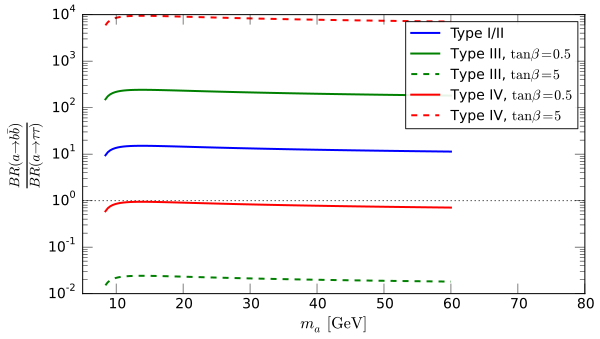

In [77]:
plt.plot(m_a, br_ratio_typ1, label='Type I/II', linewidth=2)
plt.plot(m_a, br_ratio_typ3_tb0p5, label='Type III, '+r'$\tan\beta=0.5$', linewidth=2, color='green')
plt.plot(m_a, br_ratio_typ3_tb5, label='Type III, '+r'$\tan\beta=5$', linewidth=2, color='green', linestyle='dashed')
plt.plot(m_a, br_ratio_typ4_tb0p5, label='Type IV, '+r'$\tan\beta=0.5$', linewidth=2, color='red')
plt.plot(m_a, br_ratio_typ4_tb5, label='Type IV, '+r'$\tan\beta=5$', linewidth=2, color='red', linestyle='dashed')
plt.xlim(5, 80)
leg = plt.legend(loc=0, fontsize=14)
leg.get_frame().set_alpha(0.9)
plt.yscale('log')
plt.ylabel(r'$\frac{BR(a\to b\bar{b})}{BR(a\to \tau\tau)}$', fontsize=20)
plt.xlabel(r'$m_a\mathrm{\ [GeV]}$')
plt.hlines(1, *plt.xlim(), linestyle='dotted')

Plot the ratio as a function on $\tan\beta$ for choice $m_a$:

In [78]:
m_a_few = [10., 50.]
tg_beta = np.logspace(np.log10(0.3), np.log10(30), 20)

br_ratio_typ3_masses = [np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 3, tb) for tb in tg_beta]) for m in m_a_few]
br_ratio_typ4_masses = [np.array([ll_to_qq(m, M_TAU,  m_b_msbar(m), 4, tb) for tb in tg_beta]) for m in m_a_few]

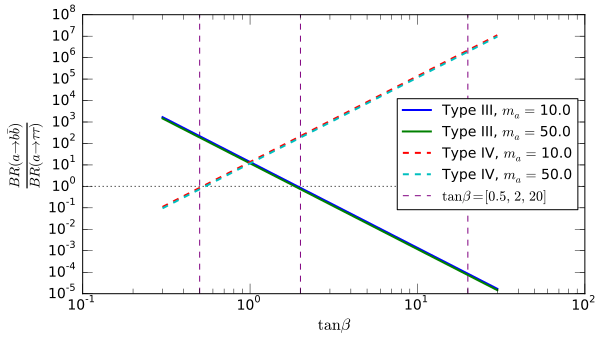

In [79]:
for m, br in zip(m_a_few, br_ratio_typ3_masses):
    plt.plot(tg_beta, br, label='Type III, '+r'$m_a =\ $' + str(m), linewidth=2)

for m, br in zip(m_a_few, br_ratio_typ4_masses):
    plt.plot(tg_beta, br, label='Type IV, '+r'$m_a =\ $' + str(m), linestyle='dashed', linewidth=2)

plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\frac{BR(a\to b\bar{b})}{BR(a\to \tau\tau)}$', fontsize=20)
plt.xlabel(r'$\tan\beta$')
plt.hlines(1, *plt.xlim(), linestyle='dotted')
plt.vlines([0.5, 2, 20], *plt.ylim(), linestyle='dashed', 
           color='purple', linewidth=1, label=r'$\tan\beta = [0.5,\ 2,\ 20]$')
# plt.grid()
leg = plt.legend(loc=0, fontsize=14)
leg.get_frame().set_alpha(1)


# Absolute values of BR(a -> ff)

To plot BR(h->aa), we need the absolute values of BR(a->ff). This is not trivial, and depends on $\tan(\beta)$...

In [80]:
def width_a_to_ll(m_a, m_l, model_type, tan_beta):
    """Calculate BR(a->lepton lepton).
    
    model_type : {1, 2, 3, 4}
    """
    coupling = g_all(model_type, tan_beta)
    return (G_F * coupling**2 * m_a * m_l**2 * velocity(m_l, m_a)) / (4. * sqrt2 * PI)

In [81]:
def width_a_to_qq(m_a, m_quark_fn, quark_type, model_type, tan_beta):
    """Calculate BR(a->qq). Not valid for top quark pairs!
        
    m_quark_fn : function for calculating running quark mass. 
        Will be evaulated at scale m_a
    quark_type : {'up', 'down'}
        In 2HDM+S, up type always couples to H2, so always cot(beta) factor.
        For down type, evaulates coupling for specified model_type and tan_beta
    model_type : {1, 2, 3, 4}
    """
    coupling = 1./tan_beta if quark_type == 'up' else g_aqq_down(model_type, tan_beta)
    m_quark = m_quark_fn(m_a)
#     print rad_corr(m_quark, m_a)
    return (3. * G_F * coupling**2 * m_a * m_quark**2 * velocity(m_quark, m_a) * rad_corr(m_quark, m_a)) / (4 * sqrt2 * PI)


In [82]:
width_a_to_qq(4, m_b_msbar, 'down', 1, 1)

0.0

In [83]:
@jit
def universal_scaling_fn(x):
    if x <= 1:
        return np.arcsin(np.sqrt(x))**2
    else:
        sqrt_thing = np.sqrt(1.-(1./x))
        return -0.25 * (np.log((1. + sqrt_thing) / (1. - sqrt_thing)) - np.pi*1j)**2

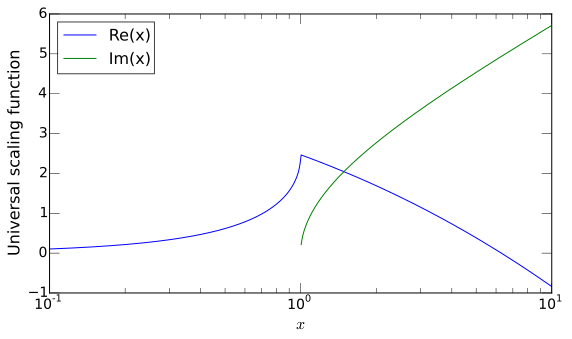

In [84]:
xxx = np.logspace(-1, 1, 500)
aaa = [universal_scaling_fn(x) for x in xxx]
plt.plot(xxx, np.real(aaa), label='Re(x)')
plt.plot(xxx[xxx>1], np.imag(aaa)[np.imag(aaa)>0], label='Im(x)')
plt.xscale('log')
plt.xlabel(r'$x$')
plt.ylabel('Universal scaling function')
plt.legend(loc=0)

In [85]:
@jit
def amplitude_spin_half(x):
    return 2. * universal_scaling_fn(x) / x

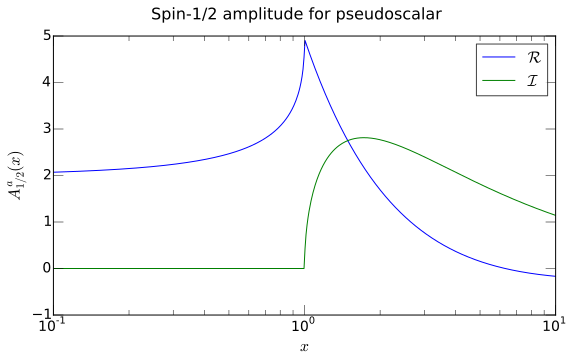

In [86]:
plt.plot(xxx, [np.real(amplitude_spin_half(x)) for x in xxx], label=r'$\mathcal{R}$')
plt.plot(xxx, [np.imag(amplitude_spin_half(x)) for x in xxx], label=r'$\mathcal{I}$')
plt.xscale('log')
plt.xlabel(r'$x$')
plt.ylabel(r'$A^a_{1/2}(x)$')
plt.suptitle('Spin-1/2 amplitude for pseudoscalar')
plt.legend(loc=0)

In [87]:
fermions = {
#             'u': {'NC': 3, 'm': None, 'g': None, 'Q': 2./3}, 
#             'd': {'NC': 3, 'm': None, 'g': g_aqq_down, 'Q': -1./3}, 
            'c': {'NC': 3, 'm': m_c_msbar, 'g': g_aqq_up, 'Q': 2./3}, 
#             's': {'NC': 3, 'm': m_s_msbar, 'g': g_aqq_down, 'Q': -1./3}, 
            't': {'NC': 3, 'm': m_t_msbar, 'g': g_aqq_up, 'Q': 2./3}, 
            'b': {'NC': 3, 'm': m_b_msbar, 'g': g_aqq_down, 'Q': -1./3}, 
#             'e': {'NC': 1, 'm': m_e, 'g': g_all, 'Q': -1.}, 
            'mu': {'NC': 1, 'm': m_mu, 'g': g_all, 'Q': -1.}, 
            'tau': {'NC': 1, 'm': m_tau, 'g': g_all, 'Q': -1.}
}


In [88]:
def width_a_to_gamgam(m_a, model_type, tan_beta):
    """Calculate BR(a->gamma gamma)
    
    model_type : {1, 2, 3, 4}
    """
    # setup couplings
    contrib = np.array([v['NC'] * v['Q']**2 * v['g'](model_type, tan_beta) * 
                        amplitude_spin_half(m_a**2 / (4. * v['m'](m_a)**2)) 
               for v in fermions.itervalues()])
#     print np.array(contrib)
    return (G_F * A_QED**2 * m_a**2 * np.real(np.sum(contrib * np.conj(contrib)))) / (128. * sqrt2 * PI**3)

In [89]:
quarks = {
#             'u': {'NC': 3, 'm': None, 'g': None, 'Q': 2./3}, 
#             'd': {'NC': 3, 'm': None, 'g': g_aqq_down, 'Q': -1./3}, 
            'c': {'NC': 3, 'm': m_c_msbar, 'g': g_aqq_up, 'Q': 2./3}, 
#             's': {'NC': 3, 'm': m_s_msbar, 'g': g_aqq_down, 'Q': -1./3}, 
            't': {'NC': 3, 'm': m_t_msbar, 'g': g_aqq_up, 'Q': 2./3}, 
            'b': {'NC': 3, 'm': m_b_msbar, 'g': g_aqq_down, 'Q': -1./3}, 
}
n_q = len(quarks)

In [90]:
def width_a_to_gluglu(m_a, model_type, tan_beta):
    """Calculate BR(a->gluon gluon)
    
    model_type : {1, 2, 3, 4}
    """
    contrib = np.array([0.75 * v['g'](model_type, tan_beta) * amplitude_spin_half(m_a**2 / (4. * v['m'](m_a)**2)) 
               for v in quarks.itervalues()])
#     print np.array(contrib)
    a_s = alpha_s(m_a)
    rad_corr = (1. + ((97./4.) - (7. * n_q/ 6.)) * (a_s/PI))
#     print rad_corr
    return (G_F * a_s**2 * m_a**3 * np.real(np.sum(contrib * np.conj(contrib)))) / (36. * sqrt2 * PI**3)

In [91]:
def total_width(m_a, model_type, tan_beta):
    return sum([
        width_a_to_ll(m_a, M_MU, model_type, tan_beta),
        width_a_to_ll(m_a, M_TAU, model_type, tan_beta),
        width_a_to_qq(m_a, m_b_msbar, 'down', model_type, tan_beta),
        width_a_to_qq(m_a, m_c_msbar, 'up', model_type, tan_beta),
        width_a_to_gamgam(m_a, model_type, tan_beta),
        width_a_to_gluglu(m_a, model_type, tan_beta)
      ])


In [92]:
mmm = np.logspace(np.log10(4), np.log10(50), 200)
widths_typ1 = np.array([total_width(m, 1, 1) for m in mmm])
widths_typ2_tb0p5 = np.array([total_width(m, 2, 0.5) for m in mmm])
widths_typ2_tb5 = np.array([total_width(m, 2, 5) for m in mmm])
widths_typ3_tb0p5 = np.array([total_width(m, 3, 0.5) for m in mmm])
widths_typ3_tb5 = np.array([total_width(m, 3, 5) for m in mmm])
widths_typ4_tb0p5 = np.array([total_width(m, 4, 0.5) for m in mmm])
widths_typ4_tb5 = np.array([total_width(m, 4, 5) for m in mmm])

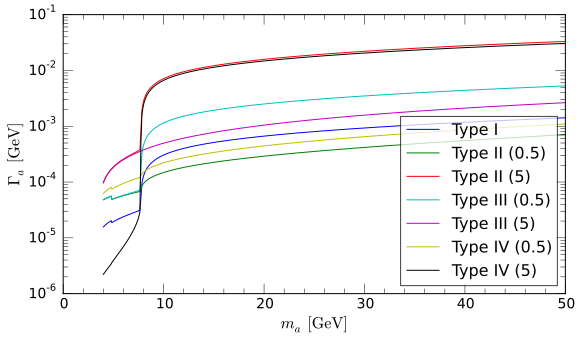

In [93]:
plt.plot(mmm, widths_typ1, label='Type I')
plt.plot(mmm, widths_typ2_tb0p5, label='Type II (0.5)')
plt.plot(mmm, widths_typ2_tb5, label='Type II (5)')
plt.plot(mmm, widths_typ3_tb0p5, label='Type III (0.5)')
plt.plot(mmm, widths_typ3_tb5, label='Type III (5)')
plt.plot(mmm, widths_typ4_tb0p5, label='Type IV (0.5)')
plt.plot(mmm, widths_typ4_tb5, label='Type IV (5)')
plt.legend(loc=0)
plt.yscale('log')
plt.ylabel(r'$\Gamma_a\ \mathrm{[GeV]}$')
plt.xlabel(r'$m_a\ \mathrm{[GeV]}$')
plt.minorticks_on()

In [94]:
def br_a_mumu(m_a, model_type, tan_beta):
    return width_a_to_ll(m_a, M_MU, model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [95]:
def br_a_tautau(m_a, model_type, tan_beta):
    return width_a_to_ll(m_a, M_TAU, model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [96]:
def br_a_bb(m_a, model_type, tan_beta):
    return width_a_to_qq(m_a, m_b_msbar, 'down', model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [97]:
def br_a_cc(m_a, model_type, tan_beta):
    return width_a_to_qq(m_a, m_c_msbar, 'up', model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [98]:
def br_a_gluglu(m_a, model_type, tan_beta):
    return width_a_to_gluglu(m_a, model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [99]:
def br_a_gamgam(m_a, model_type, tan_beta):
    return width_a_to_gamgam(m_a, model_type, tan_beta) / total_width(m_a, model_type, tan_beta)

In [100]:
def make_br_plot(model_type, tan_beta):
    masses = np.logspace(np.log10(2), np.log10(50), 500)
    br_taus = np.array([br_a_tautau(m, model_type, tan_beta) for m in masses])
    br_mus = np.array([br_a_mumu(m, model_type, tan_beta) for m in masses])
    br_bs = np.array([br_a_bb(m, model_type, tan_beta) for m in masses])
    br_cs = np.array([br_a_cc(m, model_type, tan_beta) for m in masses])
    br_glus = np.array([br_a_gluglu(m, model_type, tan_beta) for m in masses])
    br_gammas = np.array([br_a_gamgam(m, model_type, tan_beta) for m in masses])

    plt.plot(masses[br_taus>0], br_taus[br_taus>0], label=r'$\tau\tau$')
    plt.plot(masses[br_mus>0], br_mus[br_mus>0], label=r'$\mu\mu$')
    plt.plot(masses[br_bs>0], br_bs[br_bs>0], label=r'$bb$')
    plt.plot(masses[br_cs>0], br_cs[br_cs>0], label=r'$cc$')
    plt.plot(masses[br_glus>0], br_glus[br_glus>0], label=r'$gg$')
    plt.plot(masses[br_gammas>0], br_gammas[br_gammas>0], label=r'$\gamma\gamma$')
    plt.legend(loc=0)
    ax = plt.gca()
    ax.set_xlabel(r'$m_a\ \mathrm{[GeV]}$')
    ax.set_ylabel(r'$BR(a\to XX)$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 60)
    ax.set_ylim(1E-4, 1.1)
    ax.set_title('Type %s, ' % int_to_roman(model_type) + r'$\tan\beta\ =\ $' + '%g' % tan_beta, fontsize=22, y=1.02)
    
    # shaded regions for resonances
    y_lim = ax.get_ylim()
    ax.add_patch(patches.Rectangle((3, y_lim[0]), 2.1, y_lim[1]-y_lim[0], color='grey', alpha=0.5))
    ax.add_patch(patches.Rectangle((9.3, y_lim[0]), 2.3, y_lim[1]-y_lim[0], color='grey', alpha=0.5))

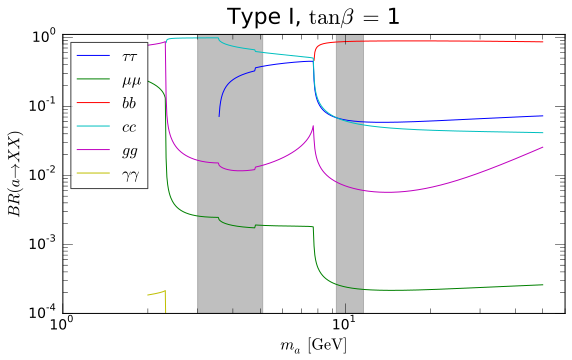

In [101]:
make_br_plot(1, 1)

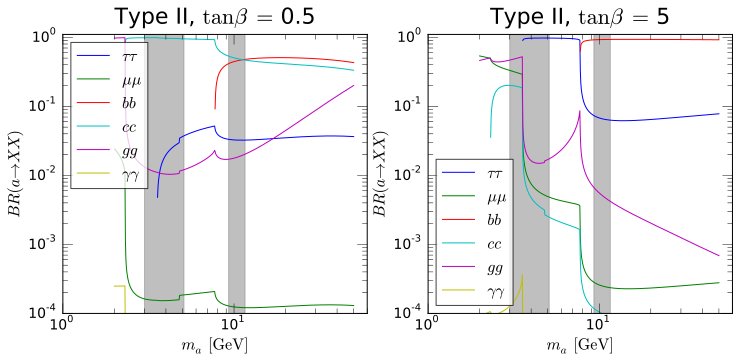

In [102]:
plt.gcf().set_size_inches(12, 5)
plt.subplot(1, 2, 1)
model = 2
make_br_plot(model, 0.5)
plt.subplot(1, 2, 2)
make_br_plot(model, 5)

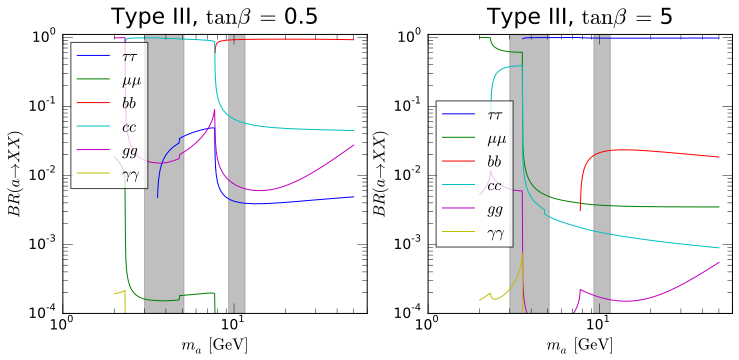

In [103]:
plt.gcf().set_size_inches(12, 5)
plt.subplot(1, 2, 1)
model = 3
make_br_plot(model, 0.5)
plt.subplot(1, 2, 2)
make_br_plot(model, 5)

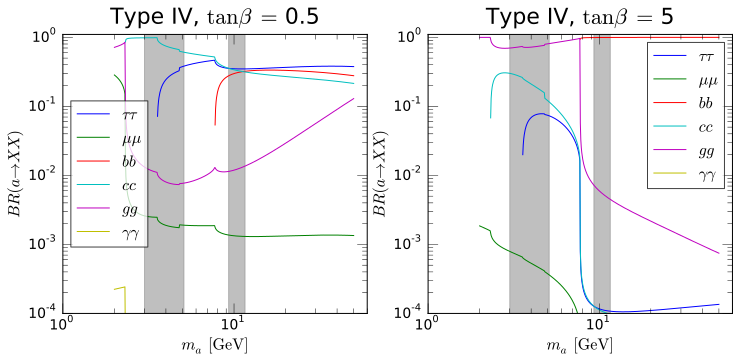

In [104]:
plt.gcf().set_size_inches(12, 5)
plt.subplot(1, 2, 1)
model = 4
make_br_plot(model, 0.5)
plt.subplot(1, 2, 2)
make_br_plot(model, 5)

# Including bb

In [105]:
br_a_tautau(27.5, 1, 1) / br_a_bb(27.5, 1, 1) 

0.073884852187553279

In [106]:
model = 3
tb = 0.5
br_a_tautau(m, model, tb) / br_a_bb(m, model, tb)

0.0052948885898438996

In [107]:
def convert_2b2mu_to_4tau(df, model_type, tan_beta, xsec=True):
    pre = 'xsec_' if xsec else ''
    tb = str(tan_beta).replace('.', 'p')
    if 'xsec_br_4tau_type%d_tb%s' % (model_type, tb) in df.columns and not xsec:
        df['br_4tau_type%d_tb%s' % (model_type, tb)] = convert_xsec_to_br(df['xsec_br_4tau_type%d_tb%s' % (model_type, tb)])
    else:
        df['%sbr_4tau_type%d_tb%s' % (pre, model_type, tb)] = np.array(
            [(b * 0.5 * br_a_tautau(m, model_type, tan_beta) * convert_BR_final_states(M_TAU, M_MU, m)) 
             / br_a_bb(m, model_type, tan_beta) 
             for m, b in izip(df['m_a'].values, df['%sbr_2b2mu' % pre].values)])

convert_2b2mu_to_4tau(df_hig_14_041, 1, 1, True)
convert_2b2mu_to_4tau(df_hig_14_041, 1, 1, False)
convert_2b2mu_to_4tau(df_hig_14_041, 2, 0.5, True)
convert_2b2mu_to_4tau(df_hig_14_041, 2, 0.5, False)
convert_2b2mu_to_4tau(df_hig_14_041, 2, 5, True)
convert_2b2mu_to_4tau(df_hig_14_041, 2, 5, False)
convert_2b2mu_to_4tau(df_hig_14_041, 3, 0.5, True)
convert_2b2mu_to_4tau(df_hig_14_041, 3, 0.5, False)
convert_2b2mu_to_4tau(df_hig_14_041, 3, 5, True)
convert_2b2mu_to_4tau(df_hig_14_041, 3, 5, False)
convert_2b2mu_to_4tau(df_hig_14_041, 4, 0.5, True)
convert_2b2mu_to_4tau(df_hig_14_041, 4, 0.5, False)
convert_2b2mu_to_4tau(df_hig_14_041, 4, 5, True)
convert_2b2mu_to_4tau(df_hig_14_041, 4, 5, False)

In [108]:
calc_other_final_states(df_hig_14_041, '_type1_tb1')
for model, tb in product([2, 3, 4], ['0p5', '5']):
    calc_other_final_states(df_hig_14_041, '_type%d_tb%s' % (model, tb))


In [109]:
df_hig_14_041.columns

Index([u'm_a', u'xsec_br_2b2mu', u'br_2b2mu', u'xsec_br_4tau_type1_tb1',
       u'br_4tau_type1_tb1', u'xsec_br_4tau_type2_tb0p5',
       u'br_4tau_type2_tb0p5', u'xsec_br_4tau_type2_tb5', u'br_4tau_type2_tb5',
       u'xsec_br_4tau_type3_tb0p5', u'br_4tau_type3_tb0p5',
       u'xsec_br_4tau_type3_tb5', u'br_4tau_type3_tb5',
       u'xsec_br_4tau_type4_tb0p5', u'br_4tau_type4_tb0p5',
       u'xsec_br_4tau_type4_tb5', u'br_4tau_type4_tb5',
       u'xsec_br_2tau2mu_type1_tb1', u'xsec_br_4mu_type1_tb1',
       u'br_2tau2mu_type1_tb1', u'br_4mu_type1_tb1',
       u'xsec_br_2tau2mu_type2_tb0p5', u'xsec_br_4mu_type2_tb0p5',
       u'br_2tau2mu_type2_tb0p5', u'br_4mu_type2_tb0p5',
       u'xsec_br_2tau2mu_type2_tb5', u'xsec_br_4mu_type2_tb5',
       u'br_2tau2mu_type2_tb5', u'br_4mu_type2_tb5',
       u'xsec_br_2tau2mu_type3_tb0p5', u'xsec_br_4mu_type3_tb0p5',
       u'br_2tau2mu_type3_tb0p5', u'br_4mu_type3_tb0p5',
       u'xsec_br_2tau2mu_type3_tb5', u'xsec_br_4mu_type3_tb5',
       u'br_2t

In [110]:
df_hig_14_041.head()

,m_a,xsec_br_2b2mu,br_2b2mu,xsec_br_4tau_type1_tb1,br_4tau_type1_tb1,xsec_br_4tau_type2_tb0p5,br_4tau_type2_tb0p5,xsec_br_4tau_type2_tb5,br_4tau_type2_tb5,xsec_br_4tau_type3_tb0p5,...,br_2tau2mu_type3_tb5,br_4mu_type3_tb5,xsec_br_2tau2mu_type4_tb0p5,xsec_br_4mu_type4_tb0p5,br_2tau2mu_type4_tb0p5,br_4mu_type4_tb0p5,xsec_br_2tau2mu_type4_tb5,xsec_br_4mu_type4_tb5,br_2tau2mu_type4_tb5,br_4mu_type4_tb5
0,27.5196850,0.0047664,0.0002474,0.0490263,0.0025442,0.0490263,0.0025442,0.0490263,0.0025442,0.0030641,...,0.0114240,0.0000205,0.0056356,0.0000101,0.0002925,0.0000005,0.0000006,1.0122101e-09,2.9245431e-08,5.2527770e-11
1,28.0393701,0.0067576,0.0003507,0.0698220,0.0036234,0.0698220,0.0036234,0.0698220,0.0036234,0.0043639,...,0.0162647,0.0000292,0.0080236,0.0000144,0.0004164,0.0000007,0.0000008,1.4406708e-09,4.1637696e-08,7.4762365e-11
2,28.5354331,0.0067020,0.0003478,0.0695422,0.0036088,0.0695422,0.0036088,0.0695422,0.0036088,0.0043464,...,0.0161950,0.0000291,0.0079892,0.0000143,0.0004146,0.0000007,0.0000008,1.4340946e-09,4.1459241e-08,7.4421101e-11
3,29.0078740,0.0051604,0.0002678,0.0537594,0.0027898,0.0537594,0.0027898,0.0537594,0.0027898,0.0033600,...,0.0125163,0.0000225,0.0061745,0.0000111,0.0003204,0.0000006,0.0000006,1.1080613e-09,3.2041831e-08,5.7501884e-11
4,29.5275591,0.0064225,0.0003333,0.0671971,0.0034871,0.0671971,0.0034871,0.0671971,0.0034871,0.0041998,...,0.0156408,0.0000281,0.0077158,0.0000138,0.0004004,0.0000007,0.0000008,1.3843005e-09,4.0040436e-08,7.1837077e-11


In [111]:
def plot_exclusion_regions_new(dfs_dict, y_var, model_type, tan_beta, 
                               y_label, x_range=None, y_range=None, 
                               title=None, shade=True, text=None, text_coords=[0.6, 0.1]):
    fname = y_var + '_type%d_tb%s' % (model_type, str(tan_beta).replace('.', 'p'))
    df = df_hig_14_041
    col = 'fuchsia'
    plt.plot(df.m_a.values, df[fname].values, 
             label='CMS HIG-14-041 '+r'$(2b2\mu)$',
             color=col, linewidth=2)
    if y_range:
        plt.ylim(*y_range)
    if shade:
        y_top = plt.ylim()[1]
        upper_edge = np.ones_like(df[fname]) * y_top
        plt.fill_between(df['m_a'], df[fname], 
                         y2=upper_edge,
                         color=col,
                         alpha=0.2)
    plot_exclusion_regions(dfs_dict, y_var, y_label, x_range=x_range, y_range=y_range, 
                           title=title, shade=shade, text=text, text_coords=text_coords)
    

## 4tau

In [112]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4tau', 1, 1, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\tau)\ \mathrm{[pb]}$',
#                            y_range=[0.005,5E4],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type I/II', text_coords=[0.1, 0.1])
# draw_xsec_sm()
# # plt.savefig("plots/xsec_br_4tau_type1.svg")

In [113]:
# plot_exclusion_regions_new(dfs_dict, 'br_4tau', 1, 1, 
#                            y_label=r'$\frac{\sigma}{\sigma_{SM}} \times\ BR\ (h\ \to\ 2a\ \to\ 4\tau)$',
#                            y_range=[1E-3,1E3],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type I/II', text_coords=[0.1, 0.1])
# draw_hline_1()
# plt.savefig("plots/br_4tau_type1.svg")

In [114]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4tau', model_type=3, tan_beta=0.5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\tau)\ \mathrm{[pb]}$',
#                            y_range=[0.000005,5E1],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type III, '+r'$\tan\beta = 0.5$', text_coords=[0.62, 0.1])
# draw_xsec_sm()
# plt.savefig("plots/xsec_br_4tau_type3_tb0p5.svg")

In [115]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4tau', model_type=3, tan_beta=5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\tau)\ \mathrm{[pb]}$',
#                            y_range=[0.1,5E4],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type III, '+r'$\tan\beta = 5$', text_coords=[0.5, 0.1])
# draw_xsec_sm()
# plt.savefig("plots/xsec_br_4tau_type3_tb5.svg")

In [116]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4tau', model_type=4, tan_beta=0.5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\tau)\ \mathrm{[pb]}$',
#                            y_range=[0.05,5E4],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type IV, '+r'$\tan\beta = 0.5$', text_coords=[0.5, 0.1])
# draw_xsec_sm()
# plt.savefig("plots/xsec_br_4tau_type4_tb0p5.svg")

In [117]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4tau', model_type=4, tan_beta=5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\tau)\ \mathrm{[pb]}$',
#                            y_range=[5E-6,1E2],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type IV, '+r'$\tan\beta = 5$', text_coords=[0.5, 0.1])
# draw_xsec_sm()
# plt.savefig("plots/xsec_br_4tau_type4_tb5.svg")

## 2mu2tau

In [118]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_2tau2mu', 1, 1, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 2\tau2\mu)\ \mathrm{[pb]}$',
#                            y_range=[1E-6,1E0],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type I/II', text_coords=[0.65, 0.1])
# draw_xsec_sm()
# plt.savefig("plots/xsec_br_2tau2mu_type1.svg")

In [119]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_2tau2mu', model_type=3, tan_beta=0.5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 2\tau2\mu)\ \mathrm{[pb]}$',
#                            y_range=[5E-8,5E-1],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type III, '+r'$\tan\beta = 0.5$', text_coords=[0.62, 0.1])
# draw_xsec_sm()
# plt.savefig("plots/xsec_br_2tau2mu_type3_tb0p5.svg")

In [120]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_2tau2mu', model_type=3, tan_beta=5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 2\tau2\mu)\ \mathrm{[pb]}$',
#                            y_range=[1E-4,5],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type III, '+r'$\tan\beta = 5$', text_coords=[0.62, 0.1])
# # draw_xsec_sm()
# plt.savefig("plots/xsec_br_2tau2mu_type3_tb5.svg")

In [121]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_2tau2mu', model_type=4, tan_beta=0.5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 2\tau2\mu)\ \mathrm{[pb]}$',
#                            y_range=[1E-4,1],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type IV, '+r'$\tan\beta = 0.5$', text_coords=[0.62, 0.1])
# # draw_xsec_sm()
# plt.savefig("plots/xsec_br_2tau2mu_type4_tb0p5.svg")

In [122]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_2tau2mu', model_type=4, tan_beta=5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 2\tau2\mu)\ \mathrm{[pb]}$',
#                            y_range=[1E-8,1],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type IV, '+r'$\tan\beta = 5$', text_coords=[0.62, 0.1])
# # draw_xsec_sm()
# plt.savefig("plots/xsec_br_2tau2mu_type4_tb5.svg")

## 4mu

In [123]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4mu', 1, 1, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\mu)\ \mathrm{[pb]}$',
#                            y_range=[5E-9,1E-3],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type I/II', text_coords=[0.65, 0.1])
# draw_xsec_sm()
# plt.savefig("plots/xsec_br_4mu_type1.svg")

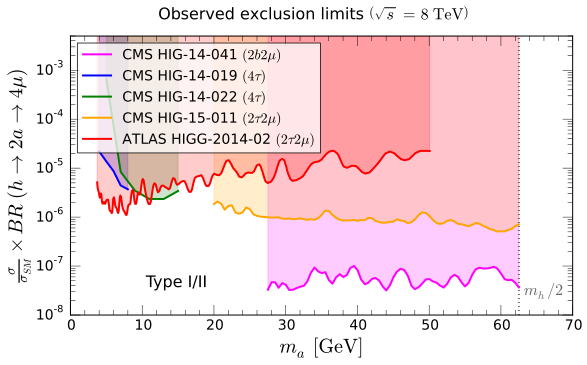

In [124]:
plot_exclusion_regions_new(dfs_dict, 'br_4mu', 1, 1, 
                           y_label=r'$\frac{\sigma}{\sigma_{SM}} \times\ BR\ (h\ \to\ 2a\ \to\ 4\mu)$',
                           y_range=[1E-8,5E-3],
                           title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
                           text='Type I/II', text_coords=[0.15, 0.1])
plt.savefig("plots/br_4mu_type1.svg")

In [125]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4mu', model_type=3, tan_beta=0.5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\mu)\ \mathrm{[pb]}$',
#                            y_range=[1E-11,1E-2],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type III, '+r'$\tan\beta = 0.5$', text_coords=[0.62, 0.1])

# plt.savefig("plots/xsec_br_4mu_type3_tb0p5.svg")

In [126]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4mu', model_type=3, tan_beta=5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\mu)\ \mathrm{[pb]}$',
#                            y_range=[1E-7,1E-2],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type III, '+r'$\tan\beta = 5$', text_coords=[0.62, 0.1])
# # draw_xsec_sm()
# plt.savefig("plots/xsec_br_4mu_type3_tb5.svg")

In [127]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4mu', model_type=4, tan_beta=0.5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\mu)\ \mathrm{[pb]}$',
#                            y_range=[1E-7,1E-3],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type IV, '+r'$\tan\beta = 0.5$', text_coords=[0.62, 0.1])
# # draw_xsec_sm()
# plt.savefig("plots/xsec_br_4mu_type4_tb0p5.svg")

In [128]:
# plot_exclusion_regions_new(dfs_dict, 'xsec_br_4mu', model_type=4, tan_beta=5, 
#                            y_label=r'$\sigma\ \times\ BR\ (h\ \to\ 2a\ \to\ 4\mu)\ \mathrm{[pb]}$',
#                            y_range=[5E-13,1E-3],
#                            title='Observed exclusion limits '+r'$\left(\sqrt{s}\ =\ 8\ \mathrm{TeV}\right)$',
#                            text='Type IV, '+r'$\tan\beta = 5$', text_coords=[0.62, 0.1])
# # draw_xsec_sm()
# plt.savefig("plots/xsec_br_4mu_type4_tb5.svg")

In [129]:
df_hig_14_041.head(10)

,m_a,xsec_br_2b2mu,br_2b2mu,xsec_br_4tau_type1_tb1,br_4tau_type1_tb1,xsec_br_4tau_type2_tb0p5,br_4tau_type2_tb0p5,xsec_br_4tau_type2_tb5,br_4tau_type2_tb5,xsec_br_4tau_type3_tb0p5,...,br_2tau2mu_type3_tb5,br_4mu_type3_tb5,xsec_br_2tau2mu_type4_tb0p5,xsec_br_4mu_type4_tb0p5,br_2tau2mu_type4_tb0p5,br_4mu_type4_tb0p5,xsec_br_2tau2mu_type4_tb5,xsec_br_4mu_type4_tb5,br_2tau2mu_type4_tb5,br_4mu_type4_tb5
0,27.5196850,0.0047664,0.0002474,0.0490263,0.0025442,0.0490263,0.0025442,0.0490263,0.0025442,0.0030641,...,0.0114240,0.0000205,0.0056356,0.0000101,0.0002925,0.0000005,0.0000006,1.0122101e-09,2.9245431e-08,5.2527770e-11
1,28.0393701,0.0067576,0.0003507,0.0698220,0.0036234,0.0698220,0.0036234,0.0698220,0.0036234,0.0043639,...,0.0162647,0.0000292,0.0080236,0.0000144,0.0004164,0.0000007,0.0000008,1.4406708e-09,4.1637696e-08,7.4762365e-11
2,28.5354331,0.0067020,0.0003478,0.0695422,0.0036088,0.0695422,0.0036088,0.0695422,0.0036088,0.0043464,...,0.0161950,0.0000291,0.0079892,0.0000143,0.0004146,0.0000007,0.0000008,1.4340946e-09,4.1459241e-08,7.4421101e-11
3,29.0078740,0.0051604,0.0002678,0.0537594,0.0027898,0.0537594,0.0027898,0.0537594,0.0027898,0.0033600,...,0.0125163,0.0000225,0.0061745,0.0000111,0.0003204,0.0000006,0.0000006,1.1080613e-09,3.2041831e-08,5.7501884e-11
4,29.5275591,0.0064225,0.0003333,0.0671971,0.0034871,0.0671971,0.0034871,0.0671971,0.0034871,0.0041998,...,0.0156408,0.0000281,0.0077158,0.0000138,0.0004004,0.0000007,0.0000008,1.3843005e-09,4.0040436e-08,7.1837077e-11
5,30.0236220,0.0058903,0.0003057,0.0618780,0.0032111,0.0618780,0.0032111,0.0618780,0.0032111,0.0038674,...,0.0143993,0.0000258,0.0071033,0.0000127,0.0003686,0.0000007,0.0000007,1.2741116e-09,3.6862094e-08,6.6118921e-11
6,30.4960630,0.0046010,0.0002388,0.0485174,0.0025178,0.0485174,0.0025178,0.0485174,0.0025178,0.0030323,...,0.0112877,0.0000202,0.0055684,0.0000100,0.0002890,0.0000005,0.0000006,9.9857371e-10,2.8896621e-08,5.1820120e-11
7,31.0393701,0.0046576,0.0002417,0.0493249,0.0025597,0.0493249,0.0025597,0.0493249,0.0025597,0.0030828,...,0.0114729,0.0000206,0.0056597,0.0000101,0.0002937,0.0000005,0.0000006,1.0147108e-09,2.9370576e-08,5.2657541e-11
8,31.5118110,0.0049945,0.0002592,0.0530867,0.0027549,0.0530867,0.0027549,0.0530867,0.0027549,0.0033179,...,0.0123455,0.0000221,0.0060902,0.0000109,0.0003160,0.0000006,0.0000006,1.0916701e-09,3.1604362e-08,5.6651277e-11
9,32.0314961,0.0053034,0.0002752,0.0565940,0.0029369,0.0565940,0.0029369,0.0565940,0.0029369,0.0035371,...,0.0131584,0.0000236,0.0064912,0.0000116,0.0003369,0.0000006,0.0000006,1.1633125e-09,3.3685393e-08,6.0369098e-11


In [130]:
width_a_to_ll(30, M_MU, 1, 1) / width_a_to_qq(30, m_b_msbar, 'down', 1, 1)

0.00027033879732058587

In [131]:
convert_BR_final_states(M_MU, m_b_msbar(30), 30)/3.

0.00036180667210918135

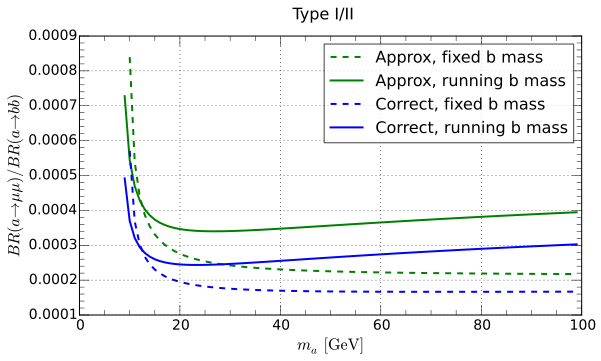

In [132]:
mmm = np.linspace(4, 50, 100)
plt.plot([convert_BR_final_states(M_MU, M_B_MSBAR_AT_POLE, m)/3. for m in mmm], 
         label='Approx, fixed b mass', linestyle='dashed', color='green', linewidth=2)
plt.plot([convert_BR_final_states(M_MU, m_b_msbar(m), m)/3. for m in mmm], 
         label='Approx, running b mass', color='green', linewidth=2)
plt.plot([width_a_to_ll(m, M_MU, 1, 1) / width_a_to_qq(m, lambda x: M_B_MSBAR_AT_POLE, 'down', 1, 1) for m in mmm], 
         label='Correct, fixed b mass', linestyle='dashed', color='blue', linewidth=2)
plt.plot([width_a_to_ll(m, M_MU, 1, 1) / width_a_to_qq(m, m_b_msbar, 'down', 1, 1) for m in mmm], 
         label='Correct, running b mass', color='blue', linewidth=2)
plt.legend()
plt.ylabel(r"$BR(a \to \mu\mu) / BR(a \to bb)$")
plt.xlabel(r"$m_a\mathrm{\ [GeV]}$")
plt.minorticks_on()
plt.grid()
plt.suptitle("Type I/II")

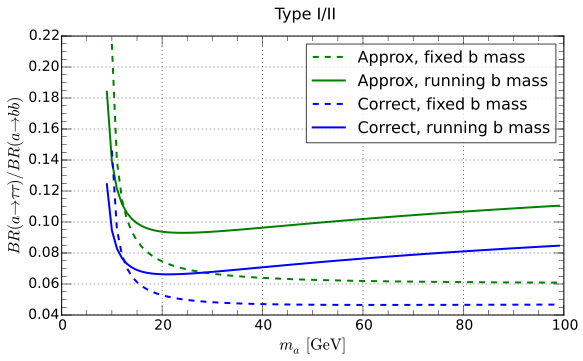

In [133]:
mmm = np.linspace(4, 50, 100)
plt.plot([convert_BR_final_states(M_TAU, M_B_MSBAR_AT_POLE, m)/3. for m in mmm], 
         label='Approx, fixed b mass', linestyle='dashed', color='green', linewidth=2)
plt.plot([convert_BR_final_states(M_TAU, m_b_msbar(m), m)/3. for m in mmm], 
         label='Approx, running b mass', color='green', linewidth=2)
plt.plot([width_a_to_ll(m, M_TAU, 1, 1) / width_a_to_qq(m, lambda x: M_B_MSBAR_AT_POLE, 'down', 1, 1) for m in mmm], 
         label='Correct, fixed b mass', linestyle='dashed', color='blue', linewidth=2)
plt.plot([width_a_to_ll(m, M_TAU, 1, 1) / width_a_to_qq(m, m_b_msbar, 'down', 1, 1) for m in mmm], 
         label='Correct, running b mass', color='blue', linewidth=2)
plt.legend()
plt.ylabel(r"$BR(a \to \tau\tau) / BR(a \to bb)$")
plt.xlabel(r"$m_a\mathrm{\ [GeV]}$")
plt.minorticks_on()
plt.grid()
plt.suptitle("Type I/II")

# Saving experimental results to file 

We save the new Dataframes to file, so other people can use them. Both as CSV, and HDF5.

In [134]:
# Save dataframes to CSV
df_hig_14_019.to_csv('CMS_HIG_14_019_full.csv')
df_hig_14_022.to_csv('CMS_HIG_14_022_full.csv')
df_hig_14_041.to_csv('CMS_HIG_14_041_full.csv')
df_hig_15_011.to_csv('CMS_HIG_15_011_full.csv')
df_atlas_higg_2014_02.to_csv('ATLAS_HIGG_2014_02_full.csv')

In [135]:
# Save dataframes to HDF5
with pd.HDFStore('exp_limits.h5') as store:
    store['CMS_HIG_14_019'] = df_hig_14_019
    store['CMS_HIG_14_022'] = df_hig_14_022
    store['CMS_HIG_14_041'] = df_hig_14_041
    store['CMS_HIG_15_011'] = df_hig_15_011
    store['ATLAS_HIGG_2014_02'] = df_atlas_higg_2014_02

In [136]:
df_hig_14_019

,m_a,br_4tau,xsec_br_4tau,xsec_br_2tau2mu,xsec_br_4mu,br_2tau2mu,br_4mu
0,4.0,0.368,7.1,0.1098483,0.0004249,0.0056935,0.0000220
1,5.0,0.535,10.3,0.1041728,0.0002634,0.0054109,0.0000137
2,6.0,0.446,8.6,0.0759769,0.0001678,0.0039402,0.0000087
3,7.0,0.259,5.0,0.0413213,0.0000854,0.0021404,0.0000044
4,8.0,0.234,4.5,0.0357680,0.0000711,0.0018599,0.0000037
